In [1]:
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import  datasets
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from PIL import Image
import numpy as np
from torch.nn import functional as F
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

## Problem 1 - Using a Pre-Trained CNN

#### Part 1

In [42]:
def load_image(filename):
    img = Image.open(filename)
    return img

labels = []

with open("labels.txt", "r") as file:
    labels.append(file.readlines())

labels_idx = list(range(0,999))

labels = dict(zip(labels_idx, labels[0]))

image = load_image('data/train/peppers.png')

transform_pipeline = transforms.Compose([transforms.Resize(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(
                                             mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])
img = transform_pipeline(image)

img = img.unsqueeze(0)

print(img.shape)


torch.Size([1, 3, 224, 298])


In [ ]:
# init pretrained model
vgg = models.vgg16(pretrained=True)

vgg.eval()

# make prediction
prediction = vgg(img)

#output top 3 frok prob distribution
hyp = F.softmax(prediction, dim=-1).data
hyp = hyp.squeeze().sort(0, True)


max_prod_ind = hyp[0].data.numpy()[:3]

max_ind = prediction.data.numpy().argsort()[0][::-1][0:3]

result = list(zip(max_ind, max_prod_ind))

[print(labels[idx], prob) for idx, prob in result]

#### Part 2

In [ ]:
class Vgg16(torch.nn.Module):
    
    def __init__(self):
        super(Vgg16, self).__init__()
        features = list(models.vgg16(pretrained = True).features)[:-2]
        self.features = torch.nn.ModuleList(features).eval()
        
    def forward(self, x):

        results = []

        for idx, model in enumerate(self.features):
            for param in model.parameters():
                param.requires_grad = False
            x = model(x)
                        
            results.append(x)
        
        return results

model = Vgg16()

feature_map = model(img)

fig, ax = plt.subplots(8, 5)
fig.set_figheight(15)
fig.set_figwidth(15)
count = 0
for i in range(0,8):
    relu1 = feature_map[-i].squeeze()
    for j in range(0,5):        
        ax[i][j].imshow(relu1[count])
        count += 1


## Problem 2 - Transfer Learning with a Pre-Trained CNN

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])


image_datasets = {"train": datasets.ImageFolder('images_new/train', transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])), "test": datasets.ImageFolder('images_new/test', transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]))
               }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4, pin_memory=True)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

train_class_names = image_datasets['train'].classes
test_class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
def train_model_norm(model, feature_extractor, criterion, optimizer, scheduler, num_epochs, num_batches):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            i = 0
            # Iterate over data.
            for images, labels in dataloaders[phase]:
                images = images.to(device)
                
                feat = feature_extractor(images)
                
                feat = feat.reshape(feat.shape[0], 25088)
                
                feat_normed = F.normalize(feat, dim = 1)
                
                inputs = feat_normed.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phasse == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                i = i + 1
                if num_batches != None:
                    if i == num_batches:
                        break
            epoch_loss = running_loss / dataset_sizes[phase]
            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_conv = models.resnet18(pretrained=True)

model_conv.eval()


model_conv = nn.Sequential(*list(model_conv.children())[:-2])

model_conv = model_conv.to(device)

linear_model = nn.Linear(25088, len(train_class_names))

linear_model = linear_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(linear_model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model_norm(
    linear_model,
    model_conv,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=25,
    num_batches=None
)

Epoch 0/24
----------
train Loss: 3.4666 Acc: 0.6867
test Loss: 3.4198 Acc: 0.8421

Epoch 1/24
----------
train Loss: 3.4358 Acc: 0.7000
test Loss: 3.3827 Acc: 0.8565

Epoch 2/24
----------
train Loss: 3.4191 Acc: 0.7671
test Loss: 3.3791 Acc: 0.8588

Epoch 3/24
----------
train Loss: 3.4133 Acc: 0.7818
test Loss: 3.3754 Acc: 0.8597

Epoch 4/24
----------
train Loss: 3.4106 Acc: 0.7760
test Loss: 3.3717 Acc: 0.8597

Epoch 5/24
----------
train Loss: 3.4075 Acc: 0.7694
test Loss: 3.3680 Acc: 0.8597

Epoch 6/24
----------
train Loss: 3.4041 Acc: 0.7712
test Loss: 3.3643 Acc: 0.8606

Epoch 7/24
----------
train Loss: 3.4005 Acc: 0.7795
test Loss: 3.3606 Acc: 0.8588

Epoch 8/24
----------
train Loss: 3.3985 Acc: 0.7799
test Loss: 3.3570 Acc: 0.8579

Epoch 9/24
----------
train Loss: 3.3963 Acc: 0.7783
test Loss: 3.3566 Acc: 0.8579

Epoch 10/24
----------
train Loss: 3.3962 Acc: 0.7683
test Loss: 3.3563 Acc: 0.8579

Epoch 11/24
----------
train Loss: 3.3957 Acc: 0.7812
test Loss: 3.3559 Acc

In [14]:
model_conv = model_conv.to(device)

In [15]:
n_classes = len(image_datasets["test"].classes)

predictions = torch.zeros(n_classes, n_classes)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):

        inputs = inputs.to(device)
        
        features = model_conv(inputs)
        
        features = features.reshape(
            features.shape[0], 
            np.prod(features.shape[-3:])
        )

        feat_normed = F.normalize(features, dim = 1)

        inputs = feat_normed.to(device)
        
        labels = labels.to(device)
            
        outputs = model_ft(inputs)
            
        _, preds = torch.max(outputs, 1)
        
        for t, p in zip(labels.view(-1), preds.view(-1)):
                predictions[t.long(), p.long()] += 1

print(predictions)


tensor([[40.,  3.,  0.,  ...,  0.,  0.,  0.],
        [ 3., 43.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 47.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 16.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 58.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 59.]])


In [17]:
mean_per_class = predictions.diag()/predictions.sum(1)

In [19]:
for i in zip(test_class_names, mean_per_class.tolist()):
    print("{} {:.2f}".format(i[0].replace('_', ' '), i[1]))

Abyssinian 0.69
Bengal 0.72
Birman 0.78
Bombay 0.77
British Shorthair 0.93
Egyptian Mau 0.87
Maine Coon 0.77
Persian 0.97
Ragdoll 0.73
Russian Blue 0.43
Siamese 0.87
Sphynx 0.83
american bulldog 0.88
american pit bull terrier 0.58
basset hound 0.97
beagle 0.77
boxer 0.87
chihuahua 0.88
english cocker spaniel 0.92
english setter 0.95
german shorthaired 0.95
great pyrenees 0.88
havanese 0.97
japanese chin 1.00
keeshond 1.00
leonberger 0.98
miniature pinscher 0.93
newfoundland 1.00
pomeranian 0.93
pug 0.98
saint bernard 0.95
samoyed 0.98
scottish terrier 0.90
shiba inu 0.95
staffordshire bull terrier 0.28
wheaten terrier 0.97
yorkshire terrier 0.98


## Problem 3 - Training a Small CNN
### Part 1

In [272]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                             shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [273]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU()
        )        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.avg_pool = nn.AvgPool2d(5, stride=1)
        
        self.fc = nn.Linear(3 * 3 * 128, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x =  self.avg_pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x


In [338]:
def train(
    model, 
    num_epochs, 
    optimizer, 
    criterion, 
    trainloader, 
    testloader):
    
    since = time.time()
    
    train_loss = []
    train_acc = np.zeros((num_epochs, len(trainloader)))
    
    test_loss = []
    test_acc = np.zeros((num_epochs, len(testloader)))

    for epoch in range(num_epochs):

        running_loss = 0.0
        test_running_loss = 0.0

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            
            train_acc[epoch, i] = torch.sum(preds == labels.data).double()/len(labels)
            
        model.eval()
        with torch.no_grad():
            for j, data_test in enumerate(testloader, 0):
                inputs, labels = data_test
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_running_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                
                test_acc[epoch, j] = torch.sum(preds == labels.data).double()/len(labels)
            
        
        train_loss.append(running_loss)
        test_loss.append(test_running_loss)
        print('Epoch {} Train Loss: {:.2f} Acc: {:.2f}'.format(epoch + 1, running_loss,\
                                        np.mean(train_acc[epoch, :])))
        print('Epoch {} Test Loss: {:.2f} Acc: {:.2f}'.format(epoch + 1, test_running_loss,\
                                        np.mean(test_acc[epoch, :])))
        
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Finished Training')
    return train_loss, train_acc, test_loss, test_acc, model


In [340]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 20
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss, train_acc, test_loss, test_acc, network = train(
    net, 
    epochs, 
    optimizer, 
    criterion,
    trainloader, 
    testloader
)

tensor([4, 0, 7, 8, 1, 7, 9, 7, 8, 1, 4, 5, 2, 0, 7, 7, 5, 9, 9, 7, 1, 8, 9, 0,
        4, 7, 9, 2, 4, 1, 6, 3, 8, 2, 8, 5, 0, 4, 1, 3, 8, 9, 8, 2, 6, 4, 7, 4,
        3, 4, 3, 9, 3, 7, 3, 6, 7, 2, 9, 0, 6, 4, 0, 8, 3, 0, 0, 5, 7, 4, 2, 5,
        2, 7, 2, 5, 6, 1, 1, 9, 1, 4, 1, 8, 7, 2, 7, 2, 6, 1, 0, 7, 1, 7, 1, 3,
        1, 3, 8, 8, 7, 0, 0, 1, 5, 4, 8, 9, 8, 4, 0, 2, 1, 7, 2, 3, 9, 5, 8, 3,
        0, 7, 4, 1, 6, 6, 4, 2], device='cuda:0')
tensor([8, 5, 5, 0, 9, 3, 0, 7, 0, 5, 7, 9, 7, 0, 0, 3, 8, 3, 7, 1, 8, 7, 0, 2,
        8, 1, 8, 5, 9, 4, 7, 0, 2, 7, 7, 5, 9, 9, 5, 8, 6, 6, 9, 7, 9, 6, 0, 7,
        6, 9, 2, 3, 9, 4, 8, 2, 3, 6, 9, 2, 8, 9, 5, 1, 2, 8, 4, 1, 9, 3, 1, 0,
        4, 6, 0, 6, 9, 2, 9, 0, 2, 8, 2, 2, 8, 8, 1, 7, 3, 8, 5, 1, 9, 4, 7, 6,
        0, 1, 3, 8, 7, 2, 4, 4, 0, 4, 3, 3, 2, 3, 4, 1, 5, 6, 2, 4, 1, 7, 2, 4,
        6, 3, 9, 8, 1, 4, 8, 0], device='cuda:0')
tensor([7, 6, 5, 5, 6, 8, 2, 4, 7, 2, 7, 2, 8, 9, 1, 4, 6, 2, 4, 3, 4, 2, 3, 3,
        0, 1, 8, 3, 

tensor([4, 9, 8, 7, 6, 1, 9, 7, 7, 6, 6, 6, 7, 1, 0, 4, 4, 9, 7, 9, 5, 9, 3, 3,
        8, 5, 7, 1, 6, 9, 3, 5, 2, 9, 6, 1, 0, 7, 3, 9, 7, 9, 6, 5, 8, 2, 1, 1,
        1, 9, 8, 4, 2, 9, 3, 4, 3, 4, 3, 8, 6, 8, 6, 3, 6, 8, 2, 5, 5, 8, 5, 0,
        8, 9, 5, 8, 7, 6, 2, 1, 0, 1, 0, 4, 8, 8, 3, 9, 1, 3, 3, 6, 9, 0, 5, 6,
        8, 7, 2, 2, 9, 4, 5, 5, 3, 3, 1, 4, 3, 9, 6, 4, 8, 2, 3, 6, 8, 6, 4, 9,
        4, 4, 9, 6, 9, 8, 8, 3], device='cuda:0')
tensor([6, 9, 6, 6, 2, 8, 2, 9, 7, 9, 2, 8, 2, 2, 4, 9, 7, 2, 5, 5, 3, 5, 9, 7,
        4, 1, 6, 7, 9, 8, 0, 7, 4, 7, 3, 0, 3, 6, 0, 7, 0, 6, 9, 3, 8, 7, 7, 0,
        7, 0, 1, 0, 1, 1, 3, 9, 4, 8, 0, 4, 8, 1, 2, 2, 7, 0, 9, 3, 7, 9, 9, 8,
        2, 9, 2, 0, 3, 6, 8, 7, 7, 9, 9, 6, 2, 2, 0, 1, 3, 8, 6, 9, 3, 8, 5, 7,
        6, 9, 8, 8, 9, 0, 5, 4, 4, 6, 3, 8, 0, 7, 7, 3, 1, 9, 1, 2, 8, 3, 8, 3,
        7, 3, 4, 4, 1, 3, 1, 6], device='cuda:0')
tensor([4, 3, 5, 3, 9, 6, 1, 1, 2, 6, 4, 3, 5, 2, 9, 6, 3, 2, 8, 1, 6, 3, 4, 8,
        0, 2, 3, 8, 

tensor([6, 2, 9, 4, 3, 3, 3, 0, 7, 6, 8, 1, 0, 1, 1, 2, 1, 6, 5, 4, 1, 3, 5, 5,
        4, 1, 0, 8, 9, 5, 0, 2, 7, 0, 0, 5, 0, 0, 9, 7, 6, 1, 6, 6, 7, 5, 2, 0,
        6, 6, 3, 3, 1, 0, 2, 4, 7, 5, 6, 1, 9, 6, 9, 1, 7, 3, 6, 2, 9, 9, 1, 3,
        3, 8, 5, 3, 9, 3, 6, 2, 5, 3, 5, 6, 2, 2, 1, 2, 0, 1, 7, 7, 0, 6, 4, 1,
        4, 6, 4, 9, 9, 4, 5, 8, 5, 1, 7, 1, 1, 2, 4, 7, 3, 4, 0, 2, 1, 5, 2, 2,
        3, 2, 3, 3, 1, 4, 6, 9], device='cuda:0')
tensor([2, 4, 6, 0, 3, 3, 2, 2, 7, 2, 2, 5, 3, 3, 0, 1, 2, 9, 9, 8, 6, 3, 5, 8,
        3, 7, 1, 7, 4, 0, 5, 7, 3, 9, 6, 1, 3, 8, 3, 2, 8, 3, 6, 6, 1, 2, 7, 7,
        2, 1, 5, 3, 5, 7, 0, 5, 1, 9, 0, 9, 2, 2, 5, 0, 9, 5, 9, 1, 7, 2, 4, 1,
        7, 1, 4, 3, 3, 7, 7, 6, 6, 4, 6, 7, 8, 4, 7, 4, 2, 9, 2, 6, 8, 5, 8, 5,
        4, 9, 8, 9, 6, 6, 6, 7, 4, 1, 1, 1, 5, 1, 0, 7, 2, 2, 9, 5, 6, 7, 2, 3,
        0, 6, 3, 1, 1, 9, 2, 3], device='cuda:0')
tensor([7, 5, 9, 1, 7, 4, 6, 8, 5, 2, 7, 8, 2, 4, 2, 5, 0, 2, 9, 2, 7, 8, 1, 4,
        2, 9, 3, 0, 

tensor([7, 6, 9, 2, 6, 0, 4, 7, 8, 7, 6, 2, 5, 6, 4, 5, 0, 2, 8, 9, 2, 6, 3, 4,
        2, 9, 9, 6, 4, 8, 3, 9, 2, 2, 3, 4, 4, 8, 5, 3, 0, 3, 4, 1, 6, 9, 1, 1,
        5, 1, 8, 0, 3, 7, 3, 6, 9, 7, 8, 3, 2, 0, 9, 4, 4, 3, 1, 7, 5, 6, 2, 2,
        6, 2, 7, 6, 1, 1, 5, 0, 9, 7, 9, 6, 8, 5, 3, 6, 3, 6, 6, 9, 7, 6, 7, 9,
        9, 5, 7, 2, 9, 1, 4, 2, 8, 4, 6, 2, 6, 1, 4, 6, 6, 0, 2, 3, 2, 3, 3, 2,
        8, 7, 9, 1, 3, 2, 8, 8], device='cuda:0')
tensor([9, 7, 4, 2, 3, 9, 1, 4, 7, 5, 8, 6, 7, 9, 5, 0, 1, 3, 5, 9, 8, 6, 7, 2,
        4, 9, 1, 5, 2, 7, 3, 7, 1, 5, 7, 7, 3, 6, 9, 8, 1, 6, 4, 0, 5, 5, 0, 2,
        1, 6, 6, 7, 2, 0, 6, 1, 9, 9, 5, 0, 9, 6, 4, 7, 4, 6, 9, 6, 4, 4, 0, 6,
        6, 3, 4, 1, 3, 5, 0, 9, 6, 3, 1, 5, 6, 1, 9, 9, 4, 6, 7, 8, 5, 2, 3, 4,
        3, 4, 8, 7, 9, 3, 1, 9, 3, 5, 7, 6, 1, 3, 5, 4, 5, 0, 3, 7, 0, 2, 2, 4,
        1, 2, 9, 8, 1, 0, 8, 9], device='cuda:0')
tensor([0, 5, 9, 6, 1, 5, 1, 3, 2, 0, 6, 7, 6, 3, 4, 5, 8, 1, 4, 7, 8, 6, 5, 2,
        7, 6, 6, 1, 

tensor([9, 3, 3, 5, 3, 4, 9, 8, 3, 5, 7, 2, 5, 5, 6, 4, 3, 6, 9, 3, 7, 2, 8, 7,
        3, 5, 4, 4, 0, 3, 7, 5, 9, 3, 6, 0, 8, 4, 8, 9, 8, 8, 8, 0, 9, 4, 6, 8,
        3, 6, 5, 0, 1, 8, 3, 2, 0, 4, 8, 3, 0, 5, 3, 2, 2, 1, 6, 6, 3, 9, 8, 0,
        1, 5, 4, 9, 3, 5, 7, 2, 6, 7, 5, 0, 2, 7, 7, 3, 8, 3, 4, 6, 4, 8, 1, 8,
        4, 3, 3, 7, 2, 0, 0, 6, 2, 0, 7, 1, 7, 6, 6, 9, 6, 7, 6, 2, 5, 8, 5, 1,
        1, 6, 6, 0, 5, 2, 1, 6], device='cuda:0')
tensor([8, 5, 7, 7, 7, 1, 6, 7, 3, 2, 2, 0, 2, 7, 7, 8, 0, 4, 5, 0, 2, 4, 3, 5,
        8, 0, 5, 9, 5, 9, 4, 6, 5, 6, 7, 4, 3, 2, 1, 3, 4, 8, 5, 9, 1, 6, 7, 8,
        7, 2, 1, 2, 2, 9, 1, 8, 1, 9, 9, 3, 2, 0, 0, 7, 1, 4, 6, 4, 5, 2, 4, 2,
        1, 1, 0, 8, 3, 1, 3, 5, 6, 1, 2, 4, 1, 3, 8, 5, 6, 2, 6, 0, 2, 3, 2, 5,
        1, 3, 4, 6, 7, 1, 8, 4, 1, 6, 9, 0, 8, 4, 6, 9, 0, 8, 2, 3, 0, 2, 7, 8,
        3, 0, 1, 7, 5, 1, 1, 8], device='cuda:0')
tensor([5, 8, 8, 1, 4, 7, 9, 4, 1, 1, 7, 3, 9, 9, 5, 7, 7, 5, 9, 5, 9, 3, 1, 0,
        6, 0, 2, 1, 

tensor([3, 3, 9, 7, 3, 8, 0, 2, 5, 9, 3, 2, 5, 8, 9, 3, 0, 0, 5, 4, 1, 5, 9, 0,
        5, 1, 4, 9, 6, 3, 2, 1, 2, 6, 8, 7, 5, 6, 5, 6, 1, 3, 0, 0, 5, 9, 9, 2,
        9, 9, 8, 7, 2, 8, 7, 3, 5, 4, 9, 7, 6, 9, 1, 9, 8, 5, 4, 4, 0, 8, 9, 6,
        6, 5, 3, 4, 6, 4, 8, 6, 4, 4, 5, 5, 6, 4, 2, 9, 7, 3, 7, 7, 0, 0, 7, 7,
        1, 1, 5, 3, 6, 7, 4, 3, 6, 6, 9, 0, 3, 3, 4, 3, 7, 5, 8, 0, 7, 1, 4, 5,
        4, 6, 2, 7, 1, 9, 7, 9], device='cuda:0')
tensor([9, 0, 3, 2, 6, 3, 1, 7, 5, 8, 7, 7, 4, 3, 6, 6, 7, 4, 1, 2, 9, 1, 9, 6,
        4, 7, 0, 5, 3, 9, 9, 8, 2, 9, 4, 7, 1, 2, 5, 1, 7, 8, 8, 9, 4, 1, 8, 7,
        1, 6, 9, 6, 9, 5, 7, 3, 0, 7, 1, 0, 0, 3, 4, 8, 7, 8, 9, 7, 8, 9, 0, 3,
        5, 0, 8, 6, 2, 2, 2, 1, 4, 0, 2, 6, 9, 7, 0, 3, 5, 2, 5, 6, 6, 6, 6, 4,
        2, 7, 2, 4, 9, 3, 2, 6, 9, 6, 8, 4, 6, 5, 4, 1, 5, 3, 0, 9, 5, 7, 3, 0,
        9, 2, 4, 2, 0, 5, 2, 0], device='cuda:0')
tensor([9, 0, 1, 7, 5, 8, 0, 0, 7, 6, 0, 4, 3, 4, 0, 3, 4, 5, 0, 1, 5, 5, 1, 2,
        4, 3, 7, 2, 

tensor([7, 0, 2, 9, 1, 5, 6, 5, 6, 6, 4, 8, 0, 9, 6, 5, 1, 6, 1, 0, 7, 6, 2, 9,
        7, 6, 3, 5, 9, 6, 6, 0, 7, 3, 0, 0, 3, 5, 6, 0, 2, 2, 6, 0, 8, 1, 6, 4,
        1, 8, 9, 3, 1, 3, 4, 2, 1, 4, 7, 4, 2, 9, 0, 0, 9, 0, 1, 3, 5, 6, 8, 6,
        1, 5, 0, 0, 8, 0, 4, 3, 0, 3, 5, 0, 1, 5, 4, 2, 3, 0, 0, 7, 8, 9, 4, 5,
        3, 0, 0, 2, 3, 4, 6, 1, 0, 3, 7, 3, 3, 1, 8, 8, 2, 4, 5, 2, 9, 5, 3, 7,
        5, 1, 2, 8, 8, 9, 0, 0], device='cuda:0')
tensor([1, 7, 6, 6, 6, 1, 1, 2, 1, 3, 6, 8, 9, 1, 1, 5, 8, 9, 7, 5, 9, 4, 6, 9,
        1, 2, 5, 5, 1, 8, 9, 3, 2, 3, 8, 9, 4, 6, 5, 2, 7, 8, 4, 4, 1, 8, 9, 4,
        8, 0, 9, 5, 4, 0, 1, 5, 7, 5, 7, 1, 0, 7, 5, 2, 2, 8, 8, 1, 0, 6, 8, 7,
        8, 0, 0, 6, 4, 3, 7, 4, 9, 4, 0, 8, 8, 1, 5, 5, 0, 8, 1, 5, 7, 0, 8, 4,
        0, 1, 0, 4, 0, 6, 2, 3, 0, 7, 1, 2, 7, 8, 0, 5, 4, 3, 1, 7, 7, 4, 2, 1,
        8, 8, 6, 2, 8, 7, 9, 8], device='cuda:0')
tensor([1, 4, 5, 1, 9, 0, 5, 7, 2, 0, 4, 3, 2, 9, 7, 4, 1, 3, 3, 8, 7, 2, 4, 8,
        2, 3, 6, 0, 

tensor([8, 8, 7, 5, 9, 8, 5, 4, 1, 3, 7, 3, 7, 8, 4, 8, 6, 0, 9, 1, 0, 7, 9, 2,
        8, 9, 0, 0, 4, 9, 2, 9, 9, 9, 7, 2, 8, 9, 7, 1, 6, 3, 7, 8, 9, 6, 3, 3,
        2, 2, 9, 9, 2, 1, 9, 3, 0, 8, 8, 2, 0, 2, 3, 6, 8, 5, 6, 6, 8, 3, 2, 6,
        9, 6, 3, 6, 8, 3, 2, 9, 1, 2, 1, 9, 2, 9, 7, 8, 6, 1, 6, 9, 7, 5, 7, 0,
        3, 3, 1, 5, 2, 3, 4, 5, 5, 1, 7, 7, 0, 0, 1, 5, 8, 3, 4, 8, 5, 1, 8, 5,
        4, 9, 1, 1, 4, 1, 4, 1], device='cuda:0')
tensor([8, 6, 8, 5, 4, 0, 5, 3, 8, 9, 0, 2, 1, 6, 6, 9, 9, 9, 8, 0, 5, 9, 5, 0,
        7, 3, 7, 9, 4, 4, 7, 0, 0, 6, 4, 0, 6, 3, 8, 0, 5, 6, 5, 2, 6, 0, 9, 5,
        7, 5, 5, 1, 3, 4, 8, 9, 2, 4, 2, 9, 6, 9, 6, 1, 6, 1, 6, 3, 2, 4, 4, 5,
        3, 3, 2, 7, 2, 9, 1, 2, 3, 7, 5, 8, 4, 7, 6, 1, 0, 4, 4, 9, 0, 8, 3, 7,
        2, 2, 5, 2, 8, 9, 4, 3, 1, 1, 7, 0, 8, 6, 8, 9, 1, 1, 2, 3, 4, 5, 5, 9,
        4, 3, 4, 1, 8, 8, 4, 4], device='cuda:0')
tensor([9, 7, 3, 3, 8, 1, 4, 1, 6, 6, 2, 8, 6, 4, 8, 4, 9, 3, 3, 2, 2, 3, 0, 6,
        9, 4, 4, 2, 

tensor([5, 5, 5, 0, 8, 7, 7, 6, 4, 4, 5, 5, 7, 0, 1, 6, 2, 7, 9, 5, 6, 6, 1, 3,
        2, 0, 1, 7, 5, 1, 1, 3, 8, 9, 5, 3, 2, 5, 0, 5, 1, 6, 3, 5, 1, 6, 9, 4,
        3, 0, 4, 1, 0, 9, 1, 1, 7, 0, 1, 2, 4, 6, 1, 6, 1, 4, 7, 2, 2, 6, 2, 2,
        3, 7, 9, 3, 5, 4, 5, 6, 2, 8, 1, 3, 6, 2, 1, 2, 2, 3, 1, 9, 1, 0, 5, 2,
        4, 0, 2, 4, 0, 7, 8, 0, 7, 6, 5, 3, 3, 3, 0, 8, 9, 2, 1, 8, 6, 2, 8, 7,
        0, 8, 4, 5, 4, 7, 6, 9], device='cuda:0')
tensor([9, 1, 5, 3, 9, 4, 9, 6, 1, 2, 6, 0, 0, 5, 2, 8, 1, 2, 0, 4, 1, 2, 3, 5,
        8, 5, 3, 3, 8, 1, 4, 2, 2, 1, 3, 2, 8, 5, 0, 3, 0, 2, 7, 2, 2, 8, 0, 9,
        1, 6, 8, 4, 8, 5, 4, 5, 3, 2, 5, 1, 1, 8, 9, 2, 4, 5, 3, 9, 7, 9, 9, 2,
        3, 2, 4, 5, 9, 0, 5, 9, 1, 4, 0, 7, 8, 6, 1, 4, 0, 8, 1, 1, 5, 1, 7, 7,
        1, 8, 6, 2, 4, 1, 2, 1, 8, 2, 6, 1, 2, 2, 8, 7, 6, 7, 6, 7, 6, 9, 7, 1,
        7, 5, 7, 2, 4, 9, 1, 9], device='cuda:0')
tensor([0, 2, 3, 2, 5, 5, 9, 2, 7, 7, 4, 8, 1, 1, 2, 8, 9, 9, 2, 5, 6, 5, 9, 5,
        6, 5, 8, 2, 

tensor([5, 7, 0, 9, 9, 2, 0, 8, 6, 3, 2, 3, 3, 7, 5, 2, 0, 1, 7, 9, 5, 9, 7, 0,
        0, 9, 8, 3, 2, 7, 5, 4, 2, 2, 5, 8, 3, 6, 5, 7, 8, 3, 1, 1, 3, 4, 8, 2,
        6, 3, 6, 8, 0, 1, 7, 9, 4, 8, 5, 4, 8, 3, 2, 2, 0, 2, 2, 7, 8, 3, 8, 9,
        5, 1, 7, 8, 1, 8, 6, 0, 8, 6, 5, 6, 7, 0, 2, 2, 1, 0, 5, 0, 9, 7, 4, 4,
        8, 9, 3, 7, 2, 0, 4, 4, 2, 2, 6, 3, 6, 7, 1, 4, 2, 7, 1, 1, 4, 4, 2, 0,
        8, 2, 4, 6, 9, 1, 0, 5], device='cuda:0')
tensor([8, 5, 4, 7, 8, 5, 0, 3, 1, 5, 2, 7, 1, 8, 1, 0, 7, 3, 4, 9, 9, 8, 8, 3,
        5, 7, 1, 3, 6, 7, 6, 2, 3, 3, 5, 5, 4, 3, 7, 0, 0, 5, 3, 0, 8, 6, 8, 2,
        5, 3, 1, 4, 4, 4, 2, 0, 6, 3, 6, 4, 0, 4, 7, 4, 1, 8, 2, 3, 6, 2, 0, 8,
        4, 2, 6, 4, 0, 3, 8, 3, 7, 5, 4, 9, 0, 5, 8, 0, 3, 5, 3, 6, 6, 2, 5, 8,
        8, 2, 6, 0, 5, 6, 5, 3, 7, 8, 5, 8, 3, 8, 6, 7, 3, 4, 4, 0, 2, 9, 5, 9,
        8, 4, 5, 5, 3, 3, 5, 1], device='cuda:0')
tensor([2, 2, 6, 4, 0, 2, 2, 0, 8, 2, 1, 1, 2, 9, 8, 7, 2, 5, 7, 5, 3, 6, 5, 2,
        6, 2, 0, 5, 

tensor([3, 8, 1, 0, 7, 7, 9, 3, 5, 5, 4, 1, 4, 2, 9, 2, 4, 0, 1, 5, 4, 1, 7, 8,
        3, 7, 4, 6, 3, 7, 3, 0, 9, 9, 8, 9, 5, 7, 6, 5, 7, 7, 6, 8, 9, 2, 8, 2,
        8, 5, 1, 0, 5, 0, 7, 5, 7, 2, 1, 9, 4, 5, 6, 2, 2, 9, 0, 2, 2, 6, 6, 7,
        7, 5, 6, 4, 3, 4, 8, 6, 1, 2, 8, 3, 7, 2, 7, 0, 5, 3, 9, 5, 7, 6, 8, 0,
        0, 2, 2, 6, 1, 3, 6, 2, 1, 1, 4, 0, 5, 4, 6, 4, 5, 4, 0, 5, 0, 3, 6, 6,
        4, 5, 7, 3, 4, 8, 4, 3], device='cuda:0')
tensor([8, 6, 1, 3, 3, 4, 4, 7, 0, 3, 9, 9, 9, 0, 0, 5, 9, 4, 5, 7, 4, 7, 3, 9,
        5, 2, 7, 3, 5, 3, 5, 6, 5, 3, 2, 0, 9, 7, 7, 6, 4, 9, 8, 4, 5, 4, 9, 2,
        8, 8, 4, 8, 6, 9, 5, 0, 6, 1, 3, 1, 3, 6, 0, 5, 1, 7, 7, 8, 5, 0, 8, 3,
        6, 0, 5, 3, 6, 2, 2, 5, 8, 1, 1, 4, 9, 2, 4, 6, 8, 2, 3, 0, 1, 5, 6, 0,
        2, 9, 7, 4, 1, 4, 1, 0, 8, 9, 9, 2, 4, 4, 1, 6, 1, 2, 3, 6, 8, 7, 1, 2,
        9, 3, 1, 8, 6, 4, 2, 9], device='cuda:0')
tensor([3, 7, 9, 8, 2, 3, 1, 9, 7, 4, 1, 9, 9, 4, 1, 0, 6, 6, 5, 1, 8, 9, 5, 3,
        2, 2, 1, 7, 

KeyboardInterrupt: 

Epoch: 20, lr: 0.0001, batch_size: 4

Train Loss: 8334.49 Acc: 0.77
Test Loss: 2076.70 Acc: 0.71

Per class accuracy:

Accuracy of plane : 75 %
Accuracy of   car : 81 %
Accuracy of  bird : 61 %
Accuracy of   cat : 51 %
Accuracy of  deer : 64 %
Accuracy of   dog : 59 %
Accuracy of  frog : 79 %
Accuracy of horse : 75 %
Accuracy of  ship : 83 %
Accuracy of truck : 79 %

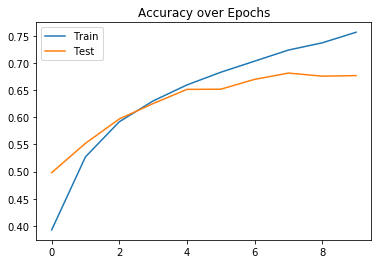

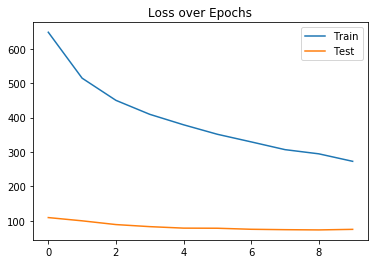

In [276]:
plt.title("Accuracy over Epochs")
plt.plot(np.mean(train_acc, axis=1), label="Train")
plt.plot(np.mean(test_acc, axis=1), label="Test")
plt.legend()
plt.show()

plt.title("Loss over Epochs")
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.legend()
plt.show()

In [277]:
def show_graph(network):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = network(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [278]:
def get_filters(network):
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    output = list(network.layer1.parameters())[0]

    fig,ax = plt.subplots(8, 8)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    filter_length = len(output)

    for i in range(filter_length):
        image = output[i].cpu().detach().numpy()
        normalized_img = (image - np.min(image))
        normalized_img = normalized_img/ np.max(normalized_img)

        x = int(i / 8)
        y = i % 8

        ax[x, y].axis('off')

        ax[x, y].imshow(np.transpose(normalized_img, (1,2,0)))


In [333]:
def init_weights(m, w_init='xavier'):
    if type(m) == nn.Linear:
        if w_init == 'xavier':
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        elif w_init == 'uniform':
            torch.nn.init.uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [279]:

epochs = 10
net = Net()
net.apply(init_weights)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

train_loss, train_acc, test_loss, test_acc, network =train_model(
    net, 
    epochs, 
    optimizer, 
    criterion,
    trainloader, 
    testloader
)

# with xavier uniform
# Epoch 10 Train Loss: 8826.17 Acc: 0.76
# Epoch 10 Test Loss: 2125.70 Acc: 0.70

# with uniform dist
# Epoch 10 Train Loss: 7281.93 Acc: 0.80
# Epoch 10 Test Loss: 2046.20 Acc: 0.72

Epoch 1 Train Loss: 665.26 Acc: 0.39
Epoch 1 Test Loss: 116.42 Acc: 0.48
Epoch 2 Train Loss: 554.98 Acc: 0.49
Epoch 2 Test Loss: 106.70 Acc: 0.52
Epoch 3 Train Loss: 514.19 Acc: 0.53
Epoch 3 Test Loss: 101.25 Acc: 0.55
Epoch 4 Train Loss: 488.85 Acc: 0.56
Epoch 4 Test Loss: 97.77 Acc: 0.57
Epoch 5 Train Loss: 469.48 Acc: 0.58
Epoch 5 Test Loss: 94.02 Acc: 0.59
Epoch 6 Train Loss: 453.88 Acc: 0.59
Epoch 6 Test Loss: 91.08 Acc: 0.59
Epoch 7 Train Loss: 441.18 Acc: 0.61
Epoch 7 Test Loss: 93.95 Acc: 0.58
Epoch 8 Train Loss: 417.48 Acc: 0.63
Epoch 8 Test Loss: 87.11 Acc: 0.61
Epoch 9 Train Loss: 413.77 Acc: 0.64
Epoch 9 Test Loss: 86.54 Acc: 0.62
Epoch 10 Train Loss: 411.87 Acc: 0.64
Epoch 10 Test Loss: 86.20 Acc: 0.62
Training complete in 0m 59s
Finished Training


ValueError: not enough values to unpack (expected 5, got 4)

## Part 2

In [287]:
class NetWithBatchNorm(nn.Module):
    def __init__(self):
        
        super(NetWithBatchNorm, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            
        )
        
        self.avg_pool = nn.AvgPool2d(5, stride=1)
        
        self.fc = nn.Linear(3 * 3 * 128, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x =  self.avg_pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)        
        return x


In [288]:
epochs = 10
net_batch_norm = NetWithBatchNorm()
net_batch_norm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_batch_norm.parameters(), lr=0.01)

train_loss_batch, train_acc_batch, test_loss_batch, test_acc_batch, network =train(
    net_batch_norm, 
    epochs,
    optimizer, 
    criterion,
    trainloader, 
    testloader
)

# Epoch 10 Train Loss: 273.04 Acc: 0.76
# Epoch 10 Test Loss: 75.57 Acc: 0.68

Epoch 1 Train Loss: 628.06 Acc: 0.41
Epoch 1 Test Loss: 107.39 Acc: 0.52
Epoch 2 Train Loss: 511.78 Acc: 0.53
Epoch 2 Test Loss: 95.73 Acc: 0.56
Epoch 3 Train Loss: 455.57 Acc: 0.58
Epoch 3 Test Loss: 90.75 Acc: 0.59
Epoch 4 Train Loss: 417.33 Acc: 0.62
Epoch 4 Test Loss: 86.15 Acc: 0.62
Epoch 5 Train Loss: 385.10 Acc: 0.65
Epoch 5 Test Loss: 83.31 Acc: 0.63
Epoch 6 Train Loss: 361.11 Acc: 0.68
Epoch 6 Test Loss: 78.56 Acc: 0.65
Epoch 7 Train Loss: 337.18 Acc: 0.70
Epoch 7 Test Loss: 79.72 Acc: 0.66
Epoch 8 Train Loss: 315.29 Acc: 0.72
Epoch 8 Test Loss: 74.78 Acc: 0.68
Epoch 9 Train Loss: 299.83 Acc: 0.73
Epoch 9 Test Loss: 80.02 Acc: 0.65
Epoch 10 Train Loss: 280.04 Acc: 0.75
Epoch 10 Test Loss: 77.94 Acc: 0.67
Training complete in 0m 58s
Finished Training


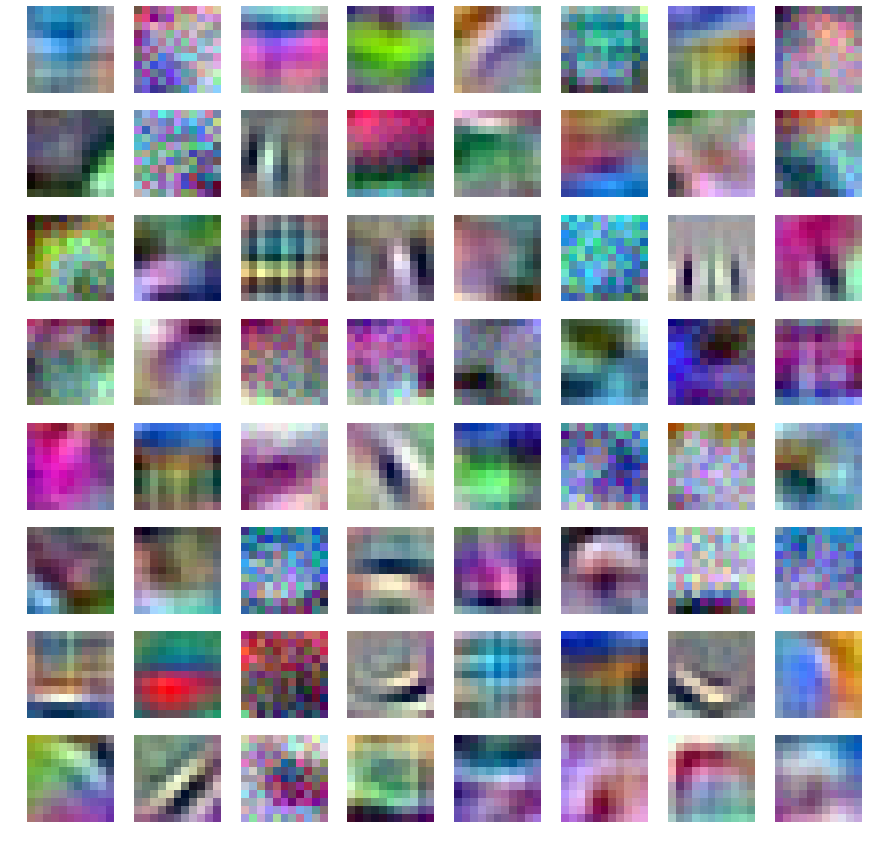

In [289]:
get_filters(network)

Accuracy of plane : 75 %
Accuracy of   car : 78 %
Accuracy of  bird : 54 %
Accuracy of   cat : 38 %
Accuracy of  deer : 48 %
Accuracy of   dog : 63 %
Accuracy of  frog : 75 %
Accuracy of horse : 52 %
Accuracy of  ship : 87 %
Accuracy of truck : 66 %


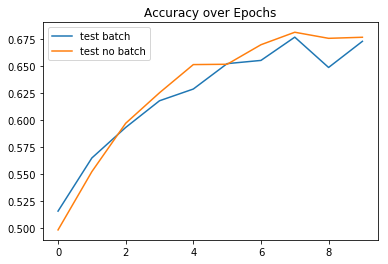

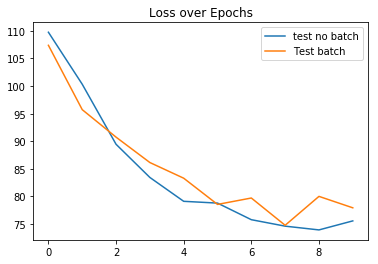

In [292]:
show_graph(network)
plt.title("Accuracy over Epochs")
plt.plot(np.mean(test_acc_batch, axis=1), label="test batch")
plt.plot(np.mean(test_acc, axis=1), label="test no batch")
plt.legend()
plt.show()

plt.title("Loss over Epochs")
plt.plot(test_loss, label="test no batch")
plt.plot(test_loss_batch, label="Test batch")
plt.legend()
plt.show()


### Part 3

In [336]:
class BetterNet(nn.Module):
    def __init__(self):
        
        super(BetterNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
#         self.avg_pool = nn.AvgPool2d(3, stride=1)
        
        self.layer_fc = nn.Sequential(
            nn.Linear(128 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

        
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.layer_fc(x)
    
        return x


In [337]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 20
better_net = BetterNet()
better_net.apply(init_weights)
better_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(better_net.parameters(), lr=0.001)

train_loss_final, train_acc_final, test_loss_final, test_acc_final, network = train(
    better_net, 
    epochs,
    optimizer, 
    criterion,
    trainloader, 
    testloader
)
# Epoch 20 Train Loss: 24.05 Acc: 0.98
# Epoch 20 Test Loss: 87.79 Acc: 0.80

Epoch 1 Train Loss: 502.21 Acc: 0.53
Epoch 1 Test Loss: 85.16 Acc: 0.64
Epoch 2 Train Loss: 337.18 Acc: 0.69
Epoch 2 Test Loss: 61.17 Acc: 0.73
Epoch 3 Train Loss: 259.17 Acc: 0.77
Epoch 3 Test Loss: 58.38 Acc: 0.75
Epoch 4 Train Loss: 210.94 Acc: 0.81
Epoch 4 Test Loss: 51.30 Acc: 0.78
Epoch 5 Train Loss: 168.67 Acc: 0.85
Epoch 5 Test Loss: 54.66 Acc: 0.78
Epoch 6 Train Loss: 131.48 Acc: 0.88
Epoch 6 Test Loss: 51.23 Acc: 0.80
Epoch 7 Train Loss: 105.02 Acc: 0.91
Epoch 7 Test Loss: 62.24 Acc: 0.78
Epoch 8 Train Loss: 83.08 Acc: 0.92
Epoch 8 Test Loss: 61.24 Acc: 0.80
Epoch 9 Train Loss: 65.81 Acc: 0.94
Epoch 9 Test Loss: 63.89 Acc: 0.79
Epoch 10 Train Loss: 57.21 Acc: 0.95
Epoch 10 Test Loss: 71.63 Acc: 0.78
Epoch 11 Train Loss: 49.26 Acc: 0.96
Epoch 11 Test Loss: 72.04 Acc: 0.79
Epoch 12 Train Loss: 40.64 Acc: 0.96
Epoch 12 Test Loss: 79.16 Acc: 0.79
Epoch 13 Train Loss: 39.91 Acc: 0.96
Epoch 13 Test Loss: 76.47 Acc: 0.79
Epoch 14 Train Loss: 38.96 Acc: 0.97
Epoch 14 Test Loss: 81.57

Accuracy of plane : 79 %
Accuracy of   car : 89 %
Accuracy of  bird : 72 %
Accuracy of   cat : 70 %
Accuracy of  deer : 74 %
Accuracy of   dog : 69 %
Accuracy of  frog : 86 %
Accuracy of horse : 84 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %


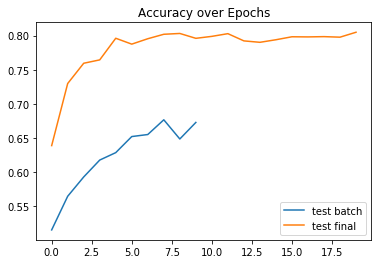

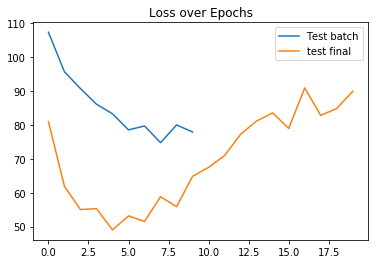

In [335]:
show_graph(network)
plt.title("Accuracy over Epochs")
plt.plot(np.mean(test_acc_batch, axis=1), label="test batch")
plt.plot(np.mean(test_acc_final, axis=1), label="test final")
plt.legend()
plt.show()

plt.title("Loss over Epochs")
plt.plot(test_loss_batch, label="Test batch")
plt.plot(test_loss_final, label="test final")
plt.legend()
plt.show()